# eCommerce Product Recommendation
The Instacart Online Grocery Shopping Dataset 2017
https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

Objective:
Recommending reordered products

## 1. Set Environment & Libraries

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Model support functions
from imblearn.pipeline import Pipeline 
from collections import OrderedDict
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Feature engineering
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import keras
# from keras.utils.vis_utils import plot_model
# from keras.wrappers.scikit_learn import KerasClassifier

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/Users/songyarong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Load Data

### 2.1 Read tables

In [3]:
aisles = pd.read_csv('/Users/songyarong/Workspace/5. Project/11. Recommendation_e-commerce/aisles.csv')
departments = pd.read_csv('/Users/songyarong/Workspace/5. Project/11. Recommendation_e-commerce/departments.csv')
orders = pd.read_csv('/Users/songyarong/Workspace/5. Project/11. Recommendation_e-commerce/orders.csv')
products = pd.read_csv('/Users/songyarong/Workspace/5. Project/11. Recommendation_e-commerce/products.csv')
order_products_prior = pd.read_csv('/Users/songyarong/Workspace/5. Project/11. Recommendation_e-commerce/order_products_prior.csv')
order_products_train = pd.read_csv('/Users/songyarong/Workspace/5. Project/11. Recommendation_e-commerce/order_products_train.csv')

### 2.2 Dimensional table

In [4]:
# Dimensional table
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [1145]:
# Dimensional table
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### 2.3 Factor table

In [1146]:
# Factor table
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [1147]:
# Factor table
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


### 2.4 Table shape

In [1148]:
print(aisles.shape)
print(departments.shape)
print(orders.shape)
print(products.shape)
print(order_products_prior.shape)
print(order_products_train.shape)

(134, 2)
(21, 2)
(82683, 7)
(49688, 4)
(793924, 4)
(53704, 4)


## 3. Data Exploration

### 3.1 Create history order table by merging the original tables
prior_order_details

In [8]:
# Expand order_products_prior
prior_order_details = order_products_prior.merge(orders, on='order_id')
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [9]:
prior_order_details.shape

(793924, 10)

In [10]:
# Convert day of week(dow) to string for better visualization and modelling 
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Sunday' if x==0 else x)
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Monday' if x==1 else x)
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Tuesday' if x==2 else x)
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Wednesday' if x==3 else x)
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Thursday' if x==4 else x)
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Friday' if x==5 else x)
prior_order_details['order_dow'] = prior_order_details['order_dow'].apply(lambda x:'Saturday' if x==6 else x)

### 3.2 General information
prior_order_details

In [11]:
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0
2,12,43772,3,1,152610,prior,22,Saturday,8,10.0
3,12,37886,4,1,152610,prior,22,Saturday,8,10.0
4,12,37215,5,0,152610,prior,22,Saturday,8,10.0


In [15]:
prior_order_details[['order_number','order_hour_of_day','days_since_prior_order']].describe()

,order_number,order_hour_of_day,days_since_prior_order
count,793924.000000,793924.000000,742704.000000
mean,16.774994,13.412193,11.295411
std,17.378097,4.223539,8.847302
min,1.000000,0.000000,0.000000
25%,5.000000,10.000000,5.000000
50%,11.000000,13.000000,8.000000
75%,23.000000,16.000000,15.000000
max,99.000000,23.000000,30.000000


In [1153]:
prior_order_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793924 entries, 0 to 793923
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                793924 non-null  int64  
 1   product_id              793924 non-null  int64  
 2   add_to_cart_order       793924 non-null  int64  
 3   reordered               793924 non-null  int64  
 4   user_id                 793924 non-null  int64  
 5   eval_set                793924 non-null  object 
 6   order_number            793924 non-null  int64  
 7   order_dow               793924 non-null  object 
 8   order_hour_of_day       793924 non-null  int64  
 9   days_since_prior_order  742704 non-null  float64
dtypes: float64(1), int64(7), object(2)
memory usage: 66.6+ MB


In [1154]:
prior_order_details.nunique()

order_id                  77683
product_id                28927
add_to_cart_order            92
reordered                     2
user_id                    5000
eval_set                      1
order_number                 99
order_dow                     7
order_hour_of_day            24
days_since_prior_order       31
dtype: int64

In [1155]:
# Missing values
prior_order_details.isnull().sum()

order_id                      0
product_id                    0
add_to_cart_order             0
reordered                     0
user_id                       0
eval_set                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    51220
dtype: int64

### 3.3 Visualization

#### 3.3.1 Order frequency based on the DOW

Text(0, 0.5, 'Order Numbers')

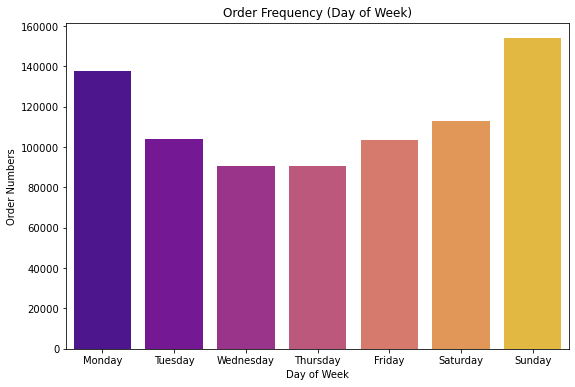

In [1156]:
f, axss = plt.subplots(1, 1, figsize = [9, 6])
# Pay attention to the order of the date
sns.countplot(palette='plasma', x='order_dow', data=prior_order_details, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Order Frequency (Day of Week)')
plt.xlabel('Day of Week')
plt.ylabel('Order Numbers')

#### 3.3.2 Order frequency based on hours

Text(0, 0.5, 'Order Numbers')

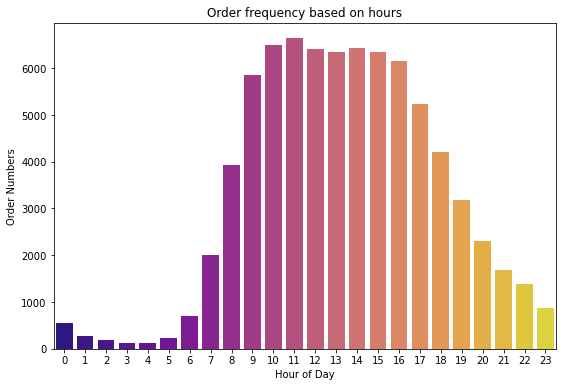

In [1157]:
f, axss = plt.subplots(1, 1, figsize = [9, 6])
order_hours = prior_order_details.groupby('order_id')['order_hour_of_day'].mean().reset_index()
# order_hours_counts = order_hours.order_hour_of_day.value_counts()
# sns.barplot(x=order_hours_counts.index, y=order_hours_counts.values)
sns.countplot(palette='plasma', x='order_hour_of_day', data=order_hours)
plt.title('Order frequency based on hours')
plt.xlabel('Hour of Day')
plt.ylabel('Order Numbers')

#### 3.3.3 Days since prior order

Text(0, 0.5, 'Order Numbers')

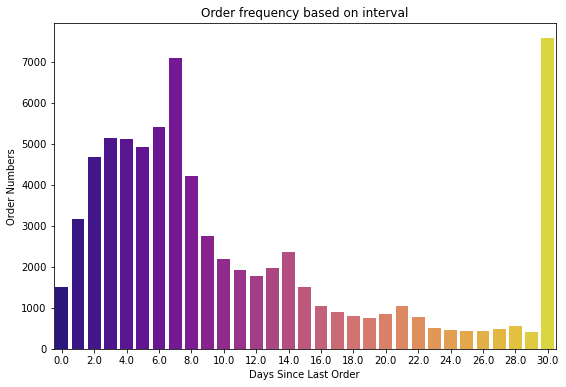

In [1158]:
f, axss = plt.subplots(1, 1, figsize = [9, 6])
days_interval = prior_order_details.groupby('order_id')['days_since_prior_order'].mean().reset_index()
sns.countplot(palette='plasma', x='days_since_prior_order', data=days_interval)
plt.title('Order frequency based on interval')
plt.xlabel('Days Since Last Order')
axss.set_xticks(np.arange(min(days_interval['days_since_prior_order']),max(days_interval['days_since_prior_order'])+1,2))
plt.ylabel('Order Numbers')

#### 3.3.4 Reorder based on HOD and DOW

Text(0.5, 42.0, 'Hours')

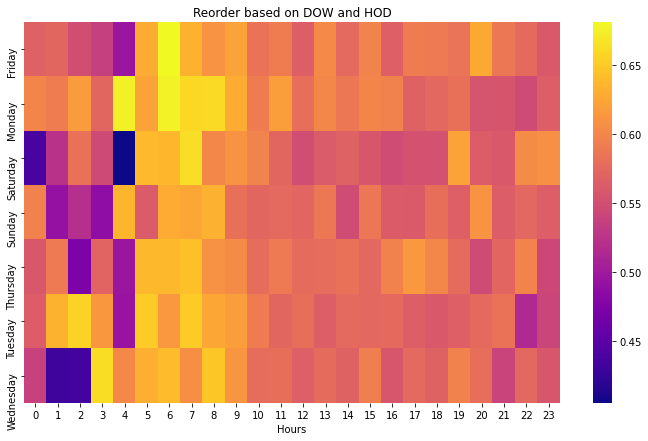

In [1159]:
# 3-dimentional
reorder_heatmap = prior_order_details.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean().reset_index()
reorder_heatmap = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')
f, axss = plt.subplots(1, 1, figsize = [12, 7])
sns.heatmap(reorder_heatmap, cmap='plasma')
plt.title('Reorder based on DOW and HOD')
plt.ylabel('')
plt.xlabel('Hours')

## 4. Data Quality Check

### 4.1 Validate the days_since_prior_order (orders table)

In [1160]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [16]:
orders.info()
# there are missing values in 'days_since_prior_order'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82683 entries, 0 to 82682
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                82683 non-null  int64  
 1   user_id                 82683 non-null  int64  
 2   eval_set                82683 non-null  object 
 3   order_number            82683 non-null  int64  
 4   order_dow               82683 non-null  int64  
 5   order_hour_of_day       82683 non-null  int64  
 6   days_since_prior_order  77683 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 4.4+ MB


In [17]:
# Numbers of order_id: each row represent an unique order_id
# orders.shape[0]
orders.order_id.nunique()

82683

In [18]:
# Numbers of unique users
orders.user_id.nunique()

5000

In [1163]:
# Numbers of NaN in days_since_prior_order
# For the first oder of each user, days_since_prior_order shoul be NaN
orders[orders.days_since_prior_order.isnull()].shape[0]

5000

In [1164]:
# Numbers of order_number == 1
orders[orders.order_number == 1].drop_duplicates().shape[0]

5000

In [1165]:
# Number of user_id
orders.user_id.drop_duplicates().shape[0]

5000

In the orders.csv, num(days_since_prior_order == NaN), num(order_number == 1), num(user_id) are the same. The values are NaN becase these are the first orders of each users.

### 4.2 Validate the order_id of orders in the prior and train tables

In [1166]:
orders.groupby(['eval_set'], as_index=False).agg({'order_id': 'nunique'}) 
# orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('order_id','nunique')]))

,eval_set,order_id
0,prior,77683
1,train,5000


In [1167]:
# Number of unique order_id in the prior
order_products_prior.order_id.nunique()

77683

In [1168]:
order_products_prior[order_products_prior.order_id.isin(orders.order_id)].order_id.nunique()

77683

order_id in the prior are all in the orders table

In [1169]:
# Number of unique order_id in the train
order_products_train.order_id.nunique()

5000

In [1170]:
order_products_train[order_products_train.order_id.isin(orders.order_id)].order_id.nunique()

5000

order_id in the prior are all in the orders table

### 4.3 Validate if there are intersection of order_ids between prior and train

In [1171]:
order_products_prior.merge(order_products_train, on='order_id').shape[0]

0

No common order_id between the prior and train thus nor data leakage.

### 4.4 Validate if the user_id maches between prior and train

In [1172]:
orders.groupby(['eval_set'], as_index=False).agg({'user_id': 'nunique'}) 

,eval_set,user_id
0,prior,5000
1,train,5000


In [1173]:
prior_user_ids = set(orders[orders.eval_set == 'prior'].user_id)
train_user_ids = set(orders[orders.eval_set == 'train'].user_id)
len(prior_user_ids.intersection(train_user_ids))

5000

### 4.5 Order counts in the train data

In [1174]:
orders[orders.eval_set=='train'].groupby(['user_id']).agg({'order_number': 'count'}).rename(columns={'order_number':'order_counts'}).sort_values(by=['order_counts'])

,order_counts
user_id,
50,1
135881,1
135743,1
135718,1
135687,1
...,...
67660,1
67640,1
67626,1


In the train table, each user only has one order

### 4.6 Validate the relative order of the order_num in prior and train dataset

In [1175]:
# Find the max order_num of each user in the prior table
df_prior_order_max = orders[orders.eval_set=='prior'].groupby(['user_id']).agg({'order_number': 'max'}).rename(columns={'order_number':'prior_order_max'})

In [1176]:
# Find the min order_num of each user in the train table
df_train_order_min = orders[orders.eval_set=='train'].groupby(['user_id']).agg({'order_number': 'min'}).rename(columns={'order_number':'train_order_min'})

In [1177]:
order_number_diff = pd.merge(df_prior_order_max, df_train_order_min, on=['user_id'])
order_number_diff[df_prior_order_max.prior_order_max >= df_train_order_min.train_order_min].shape[0]

0

Prior dataset include prior history data with smaller order_number; while train dataset include more recent orders of each user. Only the recent dataset(train) can reflect the current preference of items that users would like to buy.

## 5. Construct Model Label
Objective:
To predict if a user will reorder a certain product.

'Reordered' can't be used as the model label:
The prior data can be too long ago while the customers may have changed their buying habits. Only the labels in the train data can be considered as label.

Secondly, 1 denoted at least 1 reorder (>=1); 0 denoted no reorder.

### 5.1 train_details (order_product_train_details)

In [1178]:
train_details = order_products_train.merge(orders, on='order_id')
train_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1077,13176,1,1,173934,train,11,6,9,10.0
1,1077,39922,2,1,173934,train,11,6,9,10.0
2,1077,5258,3,1,173934,train,11,6,9,10.0
3,1077,21137,4,1,173934,train,11,6,9,10.0
4,1119,6046,1,1,129386,train,7,1,14,17.0


In [1179]:
# user_product unique key
train_unique_key = set(train_details['user_id'].astype('str') + '_' + train_details['product_id'].astype('str'))
train_unique_key

{'122846_28494',
 '159223_44616',
 '74284_32403',
 '104391_7987',
 '168102_29397',
 '197100_5456',
 '77457_34137',
 '73463_34862',
 '123163_39928',
 '36447_1831',
 '55211_41455',
 '100286_22935',
 '162048_21938',
 '52103_23909',
 '60665_7173',
 '201420_28842',
 '96682_6184',
 '164055_26111',
 '18017_12456',
 '201818_22198',
 '183599_17794',
 '108162_31268',
 '158665_28930',
 '14210_41803',
 '172790_27966',
 '42679_8678',
 '107462_9175',
 '23535_35985',
 '6668_22672',
 '51913_27845',
 '9556_27336',
 '106964_36011',
 '175595_36606',
 '52103_12290',
 '137658_7123',
 '52721_343',
 '32453_8658',
 '94464_45036',
 '33226_3376',
 '16182_40604',
 '176375_27690',
 '14332_47626',
 '166286_26165',
 '160232_17316',
 '157320_44099',
 '12317_33129',
 '32627_12312',
 '159494_93',
 '137139_46346',
 '130080_12206',
 '87291_13654',
 '167237_39515',
 '176815_24852',
 '14837_11849',
 '16832_46650',
 '76671_13535',
 '192618_24852',
 '32555_43352',
 '24784_10255',
 '26903_21536',
 '53862_32277',
 '99371_3992

In [1180]:
# user_id that we care for predictions
# create a set for easier search
train_user_id = set(train_details.user_id)

### 5.2 prior_details (order_product_prior_details)

In [1181]:
prior_details = order_products_prior.merge(orders, on='order_id')
prior_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [1182]:
# user_product unique key
prior_unique_key = prior_details['user_id'].astype('str') + '_' + prior_details['product_id'].astype('str')
prior_unique_key.head()

0    152610_30597
1    152610_15221
2    152610_43772
3    152610_37886
4    152610_37215
dtype: object

### 5.3 Real model label
Create the model data based on the prior dataset

In [1183]:
# we only care about the users in the prior dataset that also appeared in the train dataset
model_data = prior_details[prior_details.user_id.isin(train_user_id)][['user_id', 'product_id']]
model_data.shape

(793924, 2)

In [1184]:
# one user and one product only has one row
# there are lots of duplicates because some products were reordered several times
model_data = model_data.drop_duplicates(subset=['user_id','product_id'])
model_data.shape

(329806, 2)

In [1185]:
model_data['unique_key'] = model_data['user_id'].astype('str') + '_' + model_data['product_id'].astype('str')

In [1186]:
# create label
# label = 1: the user bought the product both in prior and in train
model_data['label'] = 0
model_data.loc[model_data.unique_key.isin(train_unique_key), 'label'] = 1
model_data.head()

,user_id,product_id,unique_key,label
0,152610,30597,152610_30597,0
1,152610,15221,152610_15221,0
2,152610,43772,152610_43772,0
3,152610,37886,152610_37886,0
4,152610,37215,152610_37215,0


In [1187]:
model_data.shape

(329806, 4)

In [1188]:
model_data['label'].value_counts()

0    297467
1     32339
Name: label, dtype: int64

## 6. Construct Model Features

### 6.1 user_product activity features

In [1189]:
user_product_features = ['user_product__total_orders',
                         'user_product__add_to_cart_order_mean',
                         'user_product__reordered_mean',
                         'user_product__dow_mode',
                         'user_product__hod_mode']

In [1190]:
df_user_product_features = prior_details[prior_details.user_id.isin(train_user_id)].\
                           groupby(['product_id', 'user_id'], as_index=False).\
                           agg(OrderedDict(
                           [('order_id','nunique'), 
                            ('add_to_cart_order','mean'), 
                            ('reordered','mean'), 
                            ('order_dow', (lambda x:  x.mode()[0])), 
                            ('order_hour_of_day', (lambda x: x.mode()[0]))]))

In [1191]:
df_user_product_features.columns = ['product_id', 'user_id'] + user_product_features

In [1192]:
df_user_product_features.head()

,product_id,user_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__dow_mode,user_product__hod_mode
0,1,21285,1,3.0,0.00,0,15
1,1,47549,4,4.0,0.75,2,14
2,1,54136,1,3.0,0.00,2,13
3,1,54240,1,2.0,0.00,2,16
4,1,95730,1,1.0,0.00,1,14


In [1193]:
model_all_data = df_user_product_features.merge(model_data, on=['user_id', 'product_id'])

In [1194]:
model_all_data.head()

,product_id,user_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__dow_mode,user_product__hod_mode,unique_key,label
0,1,21285,1,3.0,0.00,0,15,21285_1,0
1,1,47549,4,4.0,0.75,2,14,47549_1,0
2,1,54136,1,3.0,0.00,2,13,54136_1,0
3,1,54240,1,2.0,0.00,2,16,54240_1,0
4,1,95730,1,1.0,0.00,1,14,95730_1,0


### 6.2 product features

In [1195]:
product_features = ['product__total_orders',
                    'product__add_to_cart_order_mean',
                    'product__total_users',
                    'product__reordered_mean',
                    'product__dow_mode',
                    'product__hod_mode',
                    'product__days_since_prior_order_mean']

In [1196]:
df_product_features = prior_details[prior_details.user_id.isin(train_user_id)].\
                      groupby(['product_id'], as_index=False).\
                      agg(OrderedDict(
                      [('order_id','nunique'), 
                       ('add_to_cart_order','mean'), 
                       ('user_id', 'nunique'),
                       ('reordered','mean'), 
                       ('order_dow', (lambda x: x.mode()[0])), 
                       ('order_hour_of_day', (lambda x: x.mode()[0])),
                       ('days_since_prior_order', 'mean')]))

In [1197]:
df_product_features.columns = ['product_id'] + product_features

In [1198]:
df_product_features.head()

,product_id,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,product__dow_mode,product__hod_mode,product__days_since_prior_order_mean
0,1,26,4.576923,12,0.538462,3,10,16.280000
1,2,1,3.000000,1,0.000000,4,12,2.000000
2,3,1,4.000000,1,0.000000,4,17,30.000000
3,4,10,8.100000,5,0.500000,1,9,21.888889
4,8,1,25.000000,1,0.000000,0,13,30.000000


In [1199]:
model_all_data = df_product_features.merge(model_all_data, on=['product_id'])

In [1200]:
# extra info in the products table
model_all_data = model_all_data.merge(products[['product_id', 'aisle_id', 'department_id']],\
                                     on = 'product_id')

In [1201]:
model_all_data.rename(columns={'aisle_id': 'product__aisle_id', 'department_id': 'product__department'}, inplace=True)

In [1202]:
model_all_data.head()

,product_id,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,product__dow_mode,product__hod_mode,product__days_since_prior_order_mean,user_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__dow_mode,user_product__hod_mode,unique_key,label,product__aisle_id,product__department
0,1,26,4.576923,12,0.538462,3,10,16.28,21285,1,3.0,0.00,0,15,21285_1,0,61,19
1,1,26,4.576923,12,0.538462,3,10,16.28,47549,4,4.0,0.75,2,14,47549_1,0,61,19
2,1,26,4.576923,12,0.538462,3,10,16.28,54136,1,3.0,0.00,2,13,54136_1,0,61,19
3,1,26,4.576923,12,0.538462,3,10,16.28,54240,1,2.0,0.00,2,16,54240_1,0,61,19
4,1,26,4.576923,12,0.538462,3,10,16.28,95730,1,1.0,0.00,1,14,95730_1,0,61,19


### 6.3 user features

In [1203]:
user_features = ['user__total_orders',
                 'user__total_product',
                 'user__days_since_prior_order_mean',
                 'user__reordered_mean',
                 'user__dow_mode',
                 'user__hod_mode']

In [1204]:
df_user_features = prior_details[prior_details.user_id.isin(train_user_id)].\
                   groupby(['user_id'], as_index=False).\
                   agg(OrderedDict(
                   [('order_id','nunique'),
                    ('product_id', 'count'),
                    ('days_since_prior_order', 'mean'),
                    ('reordered','mean'), 
                    ('order_dow', (lambda x: x.mode()[0])), 
                    ('order_hour_of_day', (lambda x: x.mode()[0]))]))

In [1205]:
df_user_features.columns = ['user_id'] + user_features

In [1206]:
model_all_data = model_all_data.merge(df_user_features, on=['user_id'])

In [1207]:
model_all_data.shape

(329806, 24)

In [1208]:
model_all_data['label'].value_counts()

0    297467
1     32339
Name: label, dtype: int64

### 6.4 save data

In [1209]:
model_all_data.to_csv('/Users/songyarong/Workspace/5. Project/11. e-commerce/model_all_data.csv', index=False)

## 7. Feature Engineering

### 7.1 Confirm data columns

In [1210]:
model_all_data.head()

,product_id,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,product__dow_mode,product__hod_mode,product__days_since_prior_order_mean,user_id,user_product__total_orders,...,unique_key,label,product__aisle_id,product__department,user__total_orders,user__total_product,user__days_since_prior_order_mean,user__reordered_mean,user__dow_mode,user__hod_mode
0,1,26,4.576923,12,0.538462,3,10,16.280000,21285,1,...,21285_1,0,61,19,48,317,8.044872,0.85489,4,12
1,3298,323,5.786378,72,0.777090,1,9,11.016234,21285,1,...,21285_3298,0,21,16,48,317,8.044872,0.85489,4,12
2,4920,1967,8.350280,699,0.644637,0,15,11.600760,21285,3,...,21285_4920,0,123,4,48,317,8.044872,0.85489,4,12
3,6066,17,6.470588,4,0.764706,1,9,12.812500,21285,2,...,21285_6066,0,53,16,48,317,8.044872,0.85489,4,12
4,6184,726,3.922865,165,0.772727,1,10,10.764451,21285,6,...,21285_6184,0,32,4,48,317,8.044872,0.85489,4,12


In [1211]:
model_all_data.shape

(329806, 24)

In [1212]:
# reorder the columns
primary_keys = ['user_id', 'product_id']
features = ['user_product__total_orders',
            'user_product__add_to_cart_order_mean',
            'user_product__reordered_mean',
            'user_product__dow_mode',
            'user_product__hod_mode',
            'product__total_orders',
            'product__add_to_cart_order_mean',
            'product__total_users',
            'product__reordered_mean',
            'product__dow_mode',
            'product__hod_mode',
            'product__days_since_prior_order_mean',
            'product__aisle_id',
            'product__department',
            'user__total_orders',
            'user__total_product',
            'user__days_since_prior_order_mean',
            'user__reordered_mean',
            'user__dow_mode',
            'user__hod_mode'
            ]
label = ['label']
len(features)

20

In [1213]:
model_all_data = model_all_data[primary_keys + features + label]

In [1214]:
model_all_data.head()

,user_id,product_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__dow_mode,user_product__hod_mode,product__total_orders,product__add_to_cart_order_mean,product__total_users,...,product__days_since_prior_order_mean,product__aisle_id,product__department,user__total_orders,user__total_product,user__days_since_prior_order_mean,user__reordered_mean,user__dow_mode,user__hod_mode,label
0,21285,1,1,3.0,0.000000,0,15,26,4.576923,12,...,16.280000,61,19,48,317,8.044872,0.85489,4,12,0
1,21285,3298,1,5.0,0.000000,0,15,323,5.786378,72,...,11.016234,21,16,48,317,8.044872,0.85489,4,12,0
2,21285,4920,3,5.0,0.666667,1,9,1967,8.350280,699,...,11.600760,123,4,48,317,8.044872,0.85489,4,12,0
3,21285,6066,2,5.5,0.500000,4,10,17,6.470588,4,...,12.812500,53,16,48,317,8.044872,0.85489,4,12,0
4,21285,6184,6,7.5,0.833333,2,10,726,3.922865,165,...,10.764451,32,4,48,317,8.044872,0.85489,4,12,0


### 7.2 Data analysis

In [1215]:
label_count = model_all_data.label.value_counts()
label_count

0    297467
1     32339
Name: label, dtype: int64

In [1216]:
print("Negative label count: ", label_count[0])
print("Positive label count: ", label_count[1])
print("Positive label ratio: %.2f" % (100 * label_count[1]/(label_count[0] + label_count[1])))

Negative label count:  297467
Positive label count:  32339
Positive label ratio: 9.81


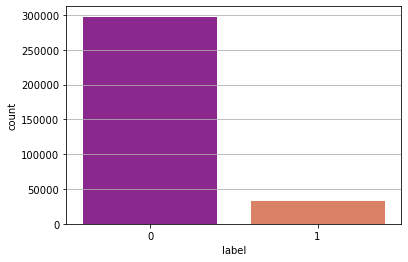

In [1217]:
f, axss = plt.subplots(1, 1, figsize = [6, 4])
sns.countplot(palette='plasma', x='label', data=model_all_data)
axss.grid(axis='y')

In [1218]:
model_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329806 entries, 0 to 329805
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   user_id                               329806 non-null  int64  
 1   product_id                            329806 non-null  int64  
 2   user_product__total_orders            329806 non-null  int64  
 3   user_product__add_to_cart_order_mean  329806 non-null  float64
 4   user_product__reordered_mean          329806 non-null  float64
 5   user_product__dow_mode                329806 non-null  int64  
 6   user_product__hod_mode                329806 non-null  int64  
 7   product__total_orders                 329806 non-null  int64  
 8   product__add_to_cart_order_mean       329806 non-null  float64
 9   product__total_users                  329806 non-null  int64  
 10  product__reordered_mean               329806 non-null  float64
 11  

In [1219]:
# missing data
model_all_data.isnull().sum()

user_id                                   0
product_id                                0
user_product__total_orders                0
user_product__add_to_cart_order_mean      0
user_product__reordered_mean              0
user_product__dow_mode                    0
user_product__hod_mode                    0
product__total_orders                     0
product__add_to_cart_order_mean           0
product__total_users                      0
product__reordered_mean                   0
product__dow_mode                         0
product__hod_mode                         0
product__days_since_prior_order_mean    726
product__aisle_id                         0
product__department                       0
user__total_orders                        0
user__total_product                       0
user__days_since_prior_order_mean         0
user__reordered_mean                      0
user__dow_mode                            0
user__hod_mode                            0
label                           

### 7.3 Categorical data

In [1220]:
# product__department
model_all_data_1 = model_all_data.drop('product__department', axis=1)
dummies1 = pd.get_dummies(model_all_data['product__department'])
model_all_data = pd.concat([model_all_data_1, dummies1], axis=1)

In [1221]:
# user_product__dow_mode
# product__dow_mod
# user__dow_mode
model_all_data_2 = model_all_data.drop(['user_product__dow_mode', 'product__dow_mode', 'user__dow_mode'], axis=1)
dummies2 = pd.get_dummies(model_all_data['user_product__dow_mode'])
dummies3 = pd.get_dummies(model_all_data['product__dow_mode'])
dummies4 = pd.get_dummies(model_all_data['user__dow_mode'])
model_all_data = pd.concat([model_all_data_2, dummies2, dummies3, dummies4], axis=1)

In [1222]:
model_all_data.head()

,user_id,product_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__hod_mode,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,...,4,5,6,0,1,2,3,4,5,6
0,21285,1,1,3.0,0.000000,15,26,4.576923,12,0.538462,...,0,0,0,0,0,0,0,1,0,0
1,21285,3298,1,5.0,0.000000,15,323,5.786378,72,0.777090,...,0,0,0,0,0,0,0,1,0,0
2,21285,4920,3,5.0,0.666667,9,1967,8.350280,699,0.644637,...,0,0,0,0,0,0,0,1,0,0
3,21285,6066,2,5.5,0.500000,10,17,6.470588,4,0.764706,...,0,0,0,0,0,0,0,1,0,0
4,21285,6184,6,7.5,0.833333,10,726,3.922865,165,0.772727,...,0,0,0,0,0,0,0,1,0,0


In [1223]:
model_all_data.shape

(329806, 61)

### 7.4 Train_test_split

In [1224]:
X = model_all_data.drop(['label'], axis=1)
y = model_all_data['label']

In [1225]:
print("Feature data: ", X.shape)
print("Label: ", y.shape)
print("Model_all_data_sc: ", model_all_data_sc.shape)

Feature data:  (329806, 60)
Label:  (329806,)
Model_all_data_sc:  (329806, 61)


In [1226]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=3)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('testing data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 263844 observation with 60 features
testing data has 65962 observation with 60 features


In [1227]:
# test data leakage
X_train[X_train.user_id.isin(X_test.user_id)].shape[0]

263073

### 7.5 Feature Scaling
Train_test_split first; then scaling

In [1228]:
features.remove('product__department')
features.remove('user_product__dow_mode')
features.remove('product__dow_mode')
features.remove('user__dow_mode')

In [1229]:
scaler = StandardScaler()
scaler.fit(X_train[features])
X_train[features] = scaler.transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

<ipython-input-1229-dc1349338bb9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features] = scaler.transform(X_train[features])
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-1229-dc1349338bb9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [1230]:
X_train.head()

,user_id,product_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__hod_mode,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,...,4,5,6,0,1,2,3,4,5,6
1091,146079,23271,-0.410002,0.514379,-0.780757,-0.398669,-0.401562,0.657460,-0.536760,-1.909333,...,0,0,0,0,1,0,0,0,0,0
156606,160926,26620,-0.410002,2.059916,-0.780757,1.500497,-0.061749,-0.572133,0.025461,0.601220,...,0,0,0,1,0,0,0,0,0,0
23284,14332,40723,1.050202,-0.914072,1.676573,-0.161274,-0.165727,-0.086641,-0.210533,0.841177,...,0,1,0,0,0,0,0,0,0,1
26111,38747,10290,-0.117961,-0.750151,0.693641,-1.110856,-0.406083,-2.085344,-0.557583,-1.399124,...,0,0,0,1,0,0,0,0,0,0
79767,107743,19784,-0.410002,0.092869,-0.780757,1.500497,-0.404576,-0.752746,-0.557583,-0.330114,...,0,0,0,0,1,0,0,0,0,0


In [1231]:
X_test.head()

,user_id,product_id,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__hod_mode,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,...,4,5,6,0,1,2,3,4,5,6
192750,171340,17634,-0.410002,-1.031158,-0.780757,-0.161274,-0.348820,0.522912,-0.422234,-0.140398,...,0,0,0,0,0,0,1,0,0,0
324512,118361,28814,-0.410002,-0.469145,-0.780757,-0.636065,-0.402316,-1.684523,-0.543701,-1.399124,...,1,0,0,0,0,0,0,0,1,0
202041,205277,4347,-0.117961,-0.539396,0.693641,-1.110856,-0.336011,-0.392082,-0.415293,0.194846,...,0,0,0,0,0,0,1,0,0,0
58888,5114,13231,-0.410002,0.233372,-0.780757,0.076122,-0.377451,1.155115,-0.439586,-1.790680,...,0,0,1,1,0,0,0,0,0,0
21173,162788,196,0.758161,-0.216239,1.578280,1.025705,0.234363,-1.761875,0.133046,1.231984,...,0,0,0,0,0,1,0,0,0,0


## 8. Modelling

### 8.1 Model selection with Cross Validation (no hyperparameter)

In [1232]:
X_train_2 = X_train.drop(['user_id', 'product_id'], axis=1)

In [1233]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

In [1234]:
# machine learning pipeline
def build_ml_pipeline(classifier):
    steps = list()
    steps.append(('fillnan', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)))
    steps.append(('downSample', RandomUnderSampler()))
    steps.append(('model', classifier))
    pipeline = Pipeline(steps=steps)
    return pipeline
      

In [1235]:
# cross_val_score: evaluate a score by cv
for classifier in classifiers:
    pipeline = build_ml_pipeline(classifier)
    %time
    scores = cross_val_score(pipeline, X_train_2, y_train, cv=5, scoring='f1')
    print(classifier, 'F1 score is %.3f (%.3g)' % (np.mean(scores), np.std(scores)))
    print('========')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LogisticRegression() F1 score is 0.334 (0.00325)
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs
DecisionTreeClassifier() F1 score is 0.250 (0.00294)
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.1 µs
RandomForestClassifier() F1 score is 0.341 (0.00315)
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs
AdaBoostClassifier() F1 score is 0.337 (0.00258)
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
GradientBoostingClassifier() F1 score is 0.342 (0.00215)


GradientBoostingClassifier performs better than others

### 8.2 Feature importance
GradientBoostingClassifier

In [1236]:
pipeline = build_ml_pipeline(GradientBoostingClassifier())
pipeline.fit(X_train_2, y_train)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('model', GradientBoostingClassifier())])

In [1237]:
importances = pipeline.steps[2][1].feature_importances_
feature_names = X_train_2.columns.tolist()

In [1238]:
df_importances = pd.DataFrame({"features": feature_names,
                               "importances": importances}).sort_values("importances", ascending=False)
top18_features = df_importances.head(18)

In [1239]:
top18_features

,features,importances
0,user_product__total_orders,0.324610
11,user__total_orders,0.294465
2,user_product__reordered_mean,0.234105
7,product__reordered_mean,0.080163
14,user__reordered_mean,0.025158
4,product__total_orders,0.010025
12,user__total_product,0.005299
13,user__days_since_prior_order_mean,0.004167
9,product__days_since_prior_order_mean,0.003350
5,product__add_to_cart_order_mean,0.003002


### 8.3 Neural Network

In [1240]:
import torch

### 8.4 Hyper-parameter tuning for GradientBoostingClassifier
Use the top 20 important features

In [1241]:
# Use the top 18 important features
df_train = pd.concat([X_train, y_train], axis=1)
sample_user_ids = df_train.user_id.drop_duplicates().sample(frac=0.1)
df_train_sample = df_train[df_train.user_id.isin(sample_user_ids)]
X_train_3 = df_train_sample[top18_features['features']]
y_train_3 = df_train_sample['label']

In [1242]:
X_train_3.shape

(27972, 20)

In [1243]:
y_train_3.shape

(27972,)

In [1244]:
para_grid = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [4, 6],
    'model__min_samples_split': [2, 4, 6],
    'model__learning_rate': [0.005, 0.01]}

In [1245]:
Grid_GBM = GridSearchCV(build_ml_pipeline(GradientBoostingClassifier()), para_grid, cv=5, scoring='f1')
Grid_GBM.fit(X_train_3, y_train_3)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fillnan',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('downSample', RandomUnderSampler()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__learning_rate': [0.005, 0.01],
                         'model__max_depth': [4, 6],
                         'model__min_samples_split': [2, 4, 6],
                         'model__n_estimators': [100, 150]},
             scoring='f1')

In [1246]:
# Best score and parameters
print("Best F1 value is %.3f" % Grid_GBM.best_score_)
print("Params are %s" % Grid_GBM.best_params_)

Best F1 value is 0.356
Params are {'model__learning_rate': 0.005, 'model__max_depth': 4, 'model__min_samples_split': 6, 'model__n_estimators': 150}


In [1247]:
best_GBM = Grid_GBM.best_estimator_

### 8.5 Train the final GradientBoostingClassifier

In [1248]:
pipeline = build_ml_pipeline(GradientBoostingClassifier(n_estimators=150, max_depth=4, min_samples_split=2, learning_rate=0.01))
pipeline.fit(X_train_2[top18_features['features']], y_train)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            n_estimators=150))])

In [1249]:
importances = pipeline.steps[2][1].feature_importances_
feature_names = X_train_2[top18_features['features']].columns.tolist()
df_importances = pd.DataFrame({"features": feature_names,
                               "importances": importances}).sort_values("importances", ascending=False)
df_importances.head(18)

,features,importances
2,user_product__reordered_mean,0.336723
0,user_product__total_orders,0.301056
1,user__total_orders,0.288524
3,product__reordered_mean,0.056794
5,product__total_orders,0.006387
10,13,0.003107
4,user__reordered_mean,0.002699
7,user__days_since_prior_order_mean,0.002077
6,user__total_product,0.001221
11,product__total_users,0.001163


## 9. Model Evaluation

### 9.1 Predict product reorder on Test data

In [1250]:
X_test_2 = X_test[top18_features['features']]

In [1251]:
predict_y = pipeline.predict(X_test_2)

In [1252]:
df_test_output = pd.DataFrame({'user_id': X_test.user_id, 
                               'product_id': X_test.product_id,
                               'predict': predict_y,
                               'label': y_test})

In [1253]:
df_test_output.head()

,user_id,product_id,predict,label
192750,171340,17634,0,0
324512,118361,28814,0,0
202041,205277,4347,1,0
58888,5114,13231,0,0
21173,162788,196,1,0


### 9.2 Evaluation
confusion matrix; accuracy; precision; recall; f1; auc  

#### 9.2.1 Plot confusion matrix

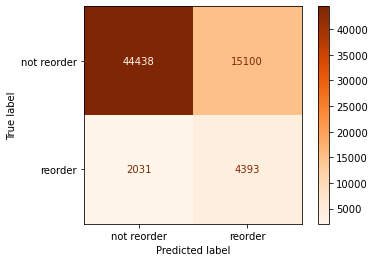

In [1254]:
# Confusion matrix
plot_confusion_matrix(pipeline, X_test_2, y_test,
                      display_labels=["not reorder","reorder"],cmap=plt.cm.Oranges)

#### 9.2.2 Acuracy, f1, precision, recall

In [1255]:
# Method 1
acc = accuracy_score(y_test, predict_y)
f1 = f1_score(y_test, predict_y)
pre = precision_score(y_test, predict_y)
rec = recall_score(y_test, predict_y)

In [1256]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("Precision : {:.4%}".format(pre))
print("Accuracy : {:.4%}".format(acc))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 33.9005%
Precision : 22.5363%
Accuracy : 74.0290%
Recall : 68.3842%


In [1257]:
# Method 2
#UDF: calculate accuracy, precision, recall, F1 score
def draw_confusion_matrices(confusion_matrices):
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy = (tn + tp)/(tn + fn + tp + fp + 0.0)
    precision = tp/(tp + fp + 0.0)
    recall = tp/(tp + fn + 0.0)
    f1 = 2/(1/recall + 1/precision + 0.0)
    print(classifier)
    print('Accuracy is: ' + str(accuracy))
    print('Precision is: ' + str(precision))
    print('Recall is: ' + str(recall))
    print('F1 score is: ' + str(f1))
    print()

In [1258]:
confusion_matrices = [('GradientBoostingClassifier', confusion_matrix(y_test,predict_y))]

In [1259]:
draw_confusion_matrices(confusion_matrices)

GradientBoostingClassifier
Accuracy is: 0.7402898638610109
Precision is: 0.22536295080285232
Recall is: 0.6838418430884184
F1 score is: 0.339005286105645



#### 9.2.3 ROC & AUC

Method 1

In [1260]:
# Use predict_proba to get the probability results of GBM
# the probability or predicting positive
predict_y_prob = pipeline.predict_proba(X_test_2)[:,1] 

In [1261]:
predict_y_prob.shape

(65962,)

In [1262]:
y_test.shape

(65962,)

In [1263]:
# Calculate false positive rate, true positive rate
fpr_lr, tpr_lr, _ = roc_curve(y_test, predict_y_prob)

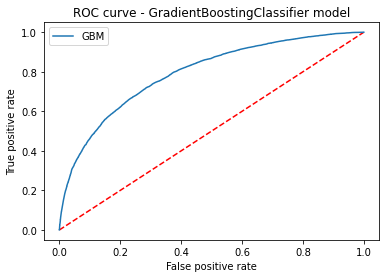

In [1264]:
# ROC curve
plt.figure(1)
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_lr, tpr_lr, label='GBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - GradientBoostingClassifier model')
plt.legend()
plt.show()

In [1265]:
# AUC score
metrics.auc(fpr_lr, tpr_lr)

0.7919460190603387

Method 2

In [1266]:
auc = roc_auc_score(y_test, predict_y_prob)
print("ROC AUC : {:.4%}".format(auc))

ROC AUC : 79.1946%
